## Global Temperature Switchpoint Regression Analysis

In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
from datetime import datetime

from scipy.stats import distributions
from scipy import stats

In [3]:
import arviz as az

In [4]:
import pymc3 as pm

import os
os.environ['MKL_THREADING_LAYER'] = "GNU" 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Data parsing

In [5]:
#string to date is a necessary and easy way to get awkard date data into something more readable
str2date = lambda x: datetime.strptime(x.decode("utf-8"), '%Y-%m-%d')

#numpy genfromtxt reads the text file of our data and converts into an array format so we can access it easily
rawdata = np.genfromtxt('GlobalTemperatures.csv', dtype=None, names=True, delimiter=',', converters={0:str2date})

### Selecting data

Since temperatures vary throughout the year, we select temps from one time during each year. I chose July because it shows the largest upward tick in temp, and should help to make the switchpoint very clear.

In [6]:
#Now to select and pull data from the raw array into specific ones we are going to implement
sel = np.zeros(len(rawdata), dtype='bool') 
for i, date in enumerate(rawdata['dt']): 
    if date.year > 1880 and date.month == 7: 
        sel[i] = True
#Here make an array of zeros as long as the data arrays we are examining.
#Enumerate attaches a counting value (kind of like an index) to each item in the array.
#We want to work with only recent data, so select years after 1880, and I selected the month july because 
# that month showed the steepest increase of temps in the more recent years, and is thus a good choice for fitting 2 lines
#After looping through and the indexes of those selected data are found with enumerate, all of the corresponding 
# indexes in 'sel' are changed from 0 to 1 or True

#With the sel array now specifying True for only the indexes we want, we call the data column of the raw data we are
# interested in and build a new array of those values when sel = true
years = np.array([date.year for date in rawdata[sel]['dt']])
temps = rawdata[sel]['LandAverageTemperature']
#We are only interested in the temperatures and corresponding years for this.

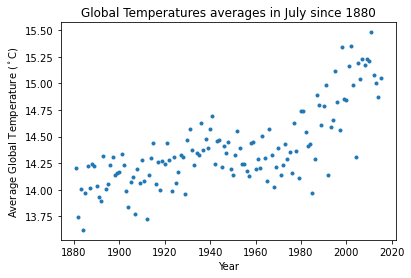

In [7]:
#Basic scatterplot just to visualize the data beforehand
plt.scatter(years, temps, marker = '.')
plt.xlabel('Year')
plt.ylabel('Average Global Temperature ($^\circ$C)')
plt.title('Global Temperatures averages in July since 1880');

### Creating the model and sampling

In [8]:
#To perform our linear regression we implement pymc3 and its Model features.
#We define a model and wrap it with a for loop (I dont know why this is just how pymc3 works)
#Then within the model we are able to define priors, likelihoods, and methods for sampling the data
with pm.Model() as temp_model:
    
    #First lets specify priors
    #We define sigma as is it necessary later when we specify the likelihood
    #We know SD should be positive so I used a halfcauchy distribution, which starts at zero and then trails off
    #The trail (tail) is necessary here and in the following priors, so that we dont 
    # completely rule out possible higher vlues with a prior that goes to zero in large regions
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    
    #The whole purpose of this regression is to come up with two linear fits, one on either side of a 'switchpoint'
    #The switchpoint value we are searching for is going to be a year, in which the data transitions from one line to another
    #We dont want to give more weight to one year than another so we use a uniform distribution as our prior
    # and since we are only looking at integer years for data lets make it discrete, we dont want switchpoint on a decimal year to confuse our data
    #There are obvisouly still upper and lower limits for the year our switchpoint, so in the end its a uniform 
    # distribution over the range of temperatures.
    #NOTE: if I wanted to infer more prior info from the data, I could look at the above graph and say
    # that I think the switchpoint is somewhere around 1980, so with this assumption we could bais our prior that way
    # by choosing a normal dist around 1980 with a SD of maybe 10
    #But I chose to not weight this prior and make it uniform, so it searches all places equally for the switchpoint
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)
    
    #The next priors we define are the parameters for the two linear lines we want to fit.
    #Chose normal distributions around zero for all of them, but chose a wider standard deviation for the prior of
    # the y-intercept as it helped our sampling and could probably vary more than the slope values
    #Slope and intercept 1 will define the regression line in the early year section of the data
    #Slope 2 will define the slope of the later line, notice there is no defined prior for the second intercept 
    intercept_1 = pm.Normal('intercept_1', 0, sd=100)
    slope_1 = pm.Normal('slope_1', 0, sd=20)
    slope_2 = pm.Normal('slope_2', 0, sd=20)
    
    #There are only 3 parameters defined as priors to sample above
    #That is because our 4th paramater for the two lines (the y-int of the later line) is really a set value based on the first line.
    #This is because I want two lines, but also for our total regression to be continuous as temperature data realistically would be.
    #We could allow for the model to also predict its own intercept for the second line, but more than likely
    # this would result in a non-continuous form.
    #The intercept_2 (more like starting point than intercept) is just y=mx+b for the first like with x as the chosen switchpoint year
    intercept_2 = slope_1 * switchpoint + intercept_1

    #Here we use the switch feature to allocate priors to different ends of the data, on either side of the swtichpoint
    #The early data is just a line as y = m1*x +b1
    #For the later years we have to factor in the 'starting point' mentioned above. 
    #Essentially make the switchpoint the x=0 line for the new slope, 
    # and the intercept for that the value of the first line evaluated at the switchpoint
    #This can be done by y2 = b1 + (m1*switchpoint) + m2*(year-switchpoint)
    mu = pm.math.switch(switchpoint >= years, slope_1 * years + intercept_1,
                        slope_2 * (years - switchpoint) + intercept_2)
    
    #Next define the likelihood. Again choose a normal distribution.
    #The center of this normal dist (mu) changes from our above description of the early line to the later line as we cross the swpt
    #Here in the likelihood is also where we feed our actual temperature data we are trying to fit to
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=temps)
    
    #Finally we sample it and the model stores all our information in trace
    #3000 samples worked sufficiently well for me and did not take too long
    #NOTE: with pymc3 we are also able to specify things in our sampling, like starting point, step method and algorithm
    #I recieved best results with the MCMC metropolis method, but it turn didnt have to speficy it as
    # pymc3.sample chooses one it thinks will work 
    #Usually when run, the sampling gives >NUTS: [slope_2, slope_1, intercept_1, sigma] and >Metropolis: [switchpoint]
    #If it does not do it this way for some reason, add in the following:
    #step1 = NUTS([intercept_1, slope_1, slope_2, sigma])
    #step2 = Metropolis([switchpoint])
    # and then call those steps within the sample function
    trace = pm.sample(3000, return_inferencedata=False) # added the last parameter becasue a pymc warning prompted me to

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [slope_2, slope_1, intercept_1, sigma]
>Metropolis: [switchpoint]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 87 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Checking posterior traces

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


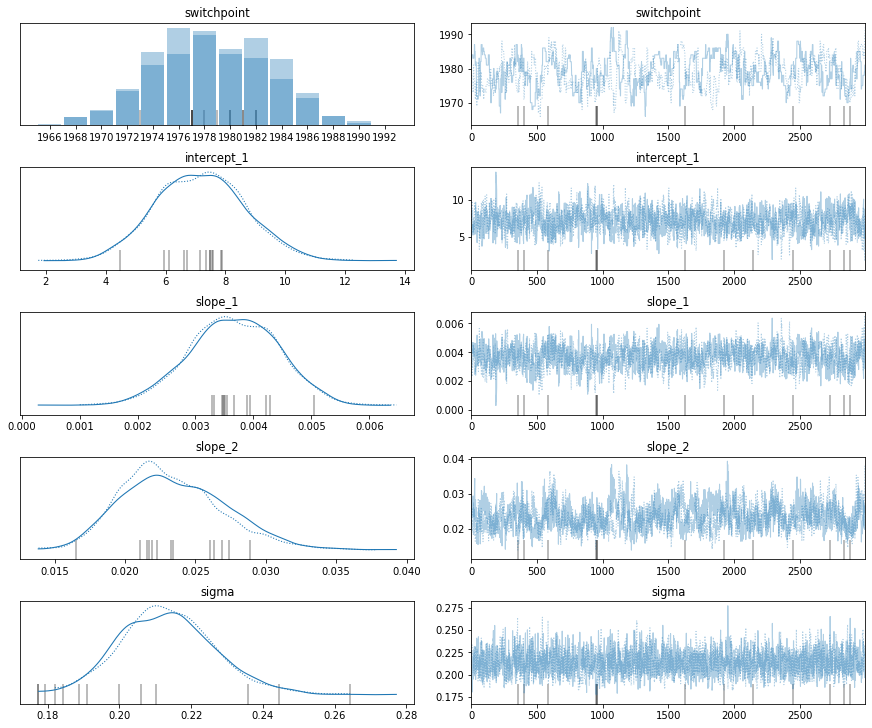

In [9]:
#Now we examine the traceplot, something pymc gives us when we input the trace we just generated from the model
pm.plot_trace(trace);

### Plot results

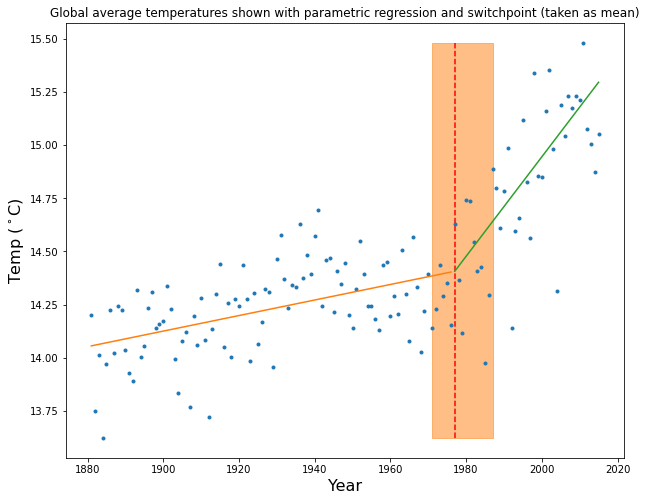

In [10]:
#Next we want to plot these regressions and our switchpoint with the data to see how it fits and represents.
#As we just generated long sample chain values for our slope and intercept parameters, we have many ways to choose which
# values specifically we are going to take from the trace and plot.
#The first way I'm going to do it it with averages, taking the mode and means of the parameter distributions as
# the values of the lines we plot.

#First just make the scatterplot again
plt.figure(figsize=(10, 8))
plt.plot(years, temps, '.')
plt.ylabel("Temp ($^\circ$C)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.title("Global average temperatures shown with parametric regression and switchpoint (taken as mean)")

#here is where I select the averages of slope, intercept and switchpoint from the trace
swpt = stats.mode(trace['switchpoint'])[0] #Switchpoint trace is in a binned histogram so I just picked the mode to use here
int1 = np.mean(trace['intercept_1'])#For the others I just used the mean values of the frequncy dists for these parameters
slope1 = np.mean(trace['slope_1'])
slope2 = np.mean(trace['slope_2'])

#Plot the switchpoint year as a vertical line
plt.vlines(swpt, temps.min(), temps.max(), linestyles = 'dashed', color='r')  

#Next we have to plot both the regressions on either side of the switchpoint
#define another select variable that tells us if we are before or after the switchpoint
#Then plot y = m1*year + int1 for years less than switchpoint
#Then plot the second line starting from where the first one ended, see above for same explaination and form of y=b1+(m1*swpt)+m2*(year-swpt)
sel = years < swpt
plt.plot(years[sel], int1 + years[sel] * slope1,)
plt.plot(years[~sel], int1 + slope1*swpt + (years[~sel] - swpt) * slope2)

#I thought it was nice on the pymc3 documentation example to see the high probability density region in the plot
#Shows us the range in which there is high probabilty the switchpoint lies, so I included it in my plots
#sp_hpd = pm.hpd(trace['switchpoint']) #pymc has a hpd feature that gets this info conveniently from trace

# Note this has changed, pymc no longer contains 'hpd' attribute. 
# Refering back to the documentation, 'arviz.hdi' is used in its place
sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(y=[temps.min(), temps.max()],
                 x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');

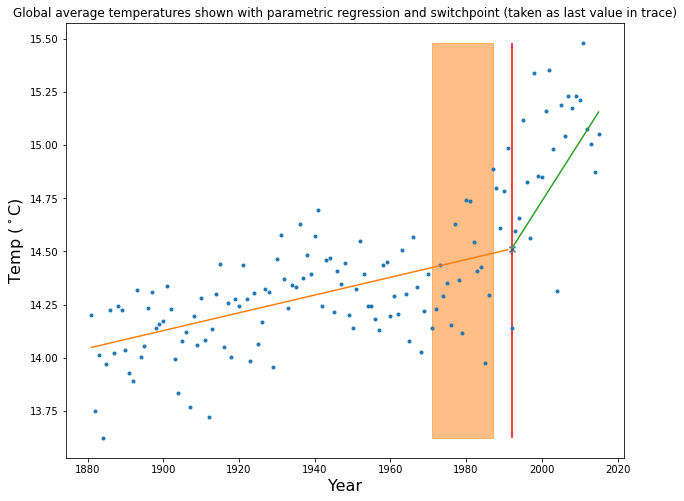

In [11]:
# as I mentioned there are many ways to pull and choose data from trace, I will show another way that worked well for me
#This time, rather than take averages, I just selected the last value in the trace sample arrays as the one to be used
#This made it easy to quickly see how the trace went.
#But remeber the final value in trace isnt neccessarily mean its the 'best', but in this case it worked and fits the data well so I use it as an example
#Everything about this plot except which swtichpoint, slopes, and intercepts are exactly selected.

plt.figure(figsize=(10, 8))
plt.plot(years, temps, '.')
plt.ylabel("Temp ($^\circ$C)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.title("Global average temperatures shown with parametric regression and switchpoint (taken as last value in trace)")

draw = trace[-1] #take last value from trace arrays as our draw for plotting the lines

plt.vlines(draw['switchpoint'], temps.min(), temps.max(), color='r')  

sel = years < draw['switchpoint']
plt.plot(years[sel], draw['intercept_1'] + years[sel] * draw['slope_1'])
plt.plot(years[~sel], draw['intercept_1'] + draw['slope_1']*draw['switchpoint'] + (years[~sel] - draw['switchpoint']) * draw['slope_2'])
plt.scatter(draw['switchpoint'], draw['intercept_1'] + draw['slope_1']*draw['switchpoint'], marker = 'x')

sp_hpd = az.hdi(trace['switchpoint'])
plt.fill_betweenx(y=[temps.min(), temps.max()],
                 x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');

#notice differences here, such as the fact that our switchpoint is no longer in the center of the high probability
# density region

In [12]:
# Using the last value in the trace is not a good practice. 
# This iteration that value landed outside the HPD for switchpoint
# The mean pf posterior traces should almost always be used

#### SOME NOTES:

There are limitations of this analysis. Finding the switchpoint year global temperatures increased does not imply that something happened that year and the trend suddenly changed. Increasing temp is likely a gradual increase cause by many factors over decades. If you wanted to estimate future temps, you would likely use an exponential or polynomial regression. Switching between two separate linear trends is likely not how global temps actually behave; in this example the linear models serve primarily to find the switchpoint, the thing we are really interested in for this analysis. 

The scope of this analysis aims to demonstrate how to utilize switchpoints, and in the context of the data, find the year we may have been able to start to notice or detect these changes in temp trends. 

### Sources:

The documentation I used to perform this analysis can be found [here](https://docs.pymc.io/notebooks/getting_started.html) on the pymc website.

The analysis performed is my own (Jonny Hofmeister), but the context for the problem, data, and guidance was provided by Professor Ben Farr at the University of Oregon. This was my midterm project for Physics 481 - Design of Experiments. Thanks Ben you're the best.